In [10]:
import numpy as np
import tensorflow as tf
from collections import deque
import gym
import threading
import time
import random
import subprocess
import sys
GITPATH = subprocess.run('git rev-parse --show-toplevel'.split(' '), \
        stdout=subprocess.PIPE).stdout.decode('utf-8').replace('\n','')
sys.path.append(GITPATH)
print(sys.path)
# import dobroEnv


['', '/opt/ros/kinetic/lib/python2.7/dist-packages', '/home/lgm/JEONGHO/ATARI/lib/python35.zip', '/home/lgm/JEONGHO/ATARI/lib/python3.5', '/home/lgm/JEONGHO/ATARI/lib/python3.5/plat-x86_64-linux-gnu', '/home/lgm/JEONGHO/ATARI/lib/python3.5/lib-dynload', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/home/lgm/JEONGHO/ATARI/lib/python3.5/site-packages', '/home/lgm/JEONGHO/ATARI/lib/python3.5/site-packages/IPython/extensions', '/home/lgm/.ipython', '', '', '', '', '', '', '', '', '']


In [2]:
!pip list

Package                       Version 
----------------------------- --------
absl-py                       0.9.0   
actionlib                     1.11.13 
angles                        1.9.11  
astor                         0.8.1   
atari-py                      0.2.6   
attrs                         19.3.0  
backcall                      0.1.0   
bleach                        3.1.0   
bondpy                        1.8.3   
camera-calibration            1.12.23 
camera-calibration-parsers    1.11.13 
catkin                        0.7.14  
cloudpickle                   1.2.2   
cv-bridge                     1.12.8  
cycler                        0.10.0  
decorator                     4.4.1   
defusedxml                    0.6.0   
diagnostic-analysis           1.9.3   
diagnostic-common-diagnostics 1.9.3   
diagnostic-updater            1.9.3   
dynamic-reconfigure           1.5.50  
entrypoints                   0.3     
future                        0.18.2  
gast                     

In [26]:
ENVIRONMENT_NAME = 'Pendulum-v0'
STATE_SHAPE = 3
# ACTION_NUMBER = 11
ACTION_DIM = 1
GAMMA = 0.99
T_MAX = 5
MAX_STEP = 500000
REPLAY_BUFFER_SIZE = 50000
SOFT_UPDATE_TAU = 0.01
BATCH_SIZE = 32
TRAIN_STARTING_POINT = 5000

In [27]:
class ReplayBuffer():
    def __init__(self):
        self.history = deque([], maxlen = REPLAY_BUFFER_SIZE)
    def update(self, state, action, reward, next_state, done):
        buffer = (state, action, reward, next_state, done)
        self.history.append(buffer)
        
    def sample_batch(self):
        batch = random.sample(self.history, BATCH_SIZE)
        return batch

In [64]:
class Agent():
    def __init__(self):
        self.replay = ReplayBuffer() # args add
                
        self.input_state = tf.placeholder(shape=(None, STATE_SHAPE),dtype=tf.float32)
        self.input_action = tf.placeholder(shape=(None, ACTION_DIM),dtype=tf.float32, name='actionph')

        self.tau = SOFT_UPDATE_TAU
        self.gamma = GAMMA
            
        self.policy_online = self._build_actor_network('online')
        self.policy_target = self._build_actor_network('target')
        
        self.value_online = self._build_critic_network('online')
        self.value_target = self._build_critic_network('target')
        
        self.online_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'online')
        self.online_policy_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'online/actor')
        self.online_value_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'online/critic')
        
        self.target_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'target')
        self.target_policy_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'target/actor')
        self.target_value_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, ' target/critic')
        
        self.target_values  = tf.placeholder(shape=(None, ACTION_DIM), dtype=tf.float32)
        self.value_loss = tf.reduce_sum(tf.square(self.value_online - self.target_values))
        self.value_gradient = tf.gradients(self.value_loss, self.online_value_variables)
        
        self.value_gradient_by_action = tf.gradients(self.value_online, self.input_action) # [batch * 1(value 개수) * actiondim(3)]  -> self.input_action이 online policy의 아웃풋임.
        self.value_gradient_by_action_placeholder = tf.placeholder(shape=(None, ACTION_DIM),dtype=tf.float32, name='vgaph')

        self.loss = - tf.matmul(tf.transpose(self.value_gradient_by_action_placeholder), self.policy_online)

        self.policy_gradient = tf.gradients(self.loss, self.online_policy_variables)
        
        self.policy_apply_grad = PolicyOptimizer.apply_gradients(zip(self.policy_gradient, self.online_policy_variables))
        self.value_apply_grad = ValueOptimizer.apply_gradients(zip(self.value_gradient, self.online_value_variables))
        
        self.target_update_ops = self._build_target_update_ops()


    def _build_actor_network(self, name):
        # actor(policy) - input: state, output: action(real number vector) 
        with tf.variable_scope(name):
            actor_L1 = tf.layers.dense(inputs=self.input_state, units=64, activation=tf.nn.relu, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='actor_1') # name = actor
            actor_L2 = tf.layers.dense(inputs=actor_L1, units=64, activation=tf.nn.relu, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='actor_2') # name = actor
            policy_output = 2 * tf.layers.dense(inputs=actor_L2, units=ACTION_DIM, activation=tf.nn.tanh, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='actor_3') # tanh activation
            
        return policy_output
    def _build_critic_network(self, name):
        # critic(Q-value) - input: state+action, output: real number Q-value
        with tf.variable_scope(name):
            critic_L1 = tf.layers.dense(inputs=tf.concat([self.input_state, self.input_action], axis=1), units=64, activation=tf.nn.relu, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='critic_1')
            critic_L2 = tf.layers.dense(inputs=critic_L1, units=64, activation=tf.nn.relu, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='critic_2')
            value_output = tf.layers.dense(inputs=critic_L2, units=1, use_bias=True, kernel_initializer=tf.contrib.layers.xavier_initializer(), name='critic_3')
        
        return value_output

            
    def sync_network(self):
        ops = []
        for target_var, online_var in zip(self.target_variables, self.online_variables):
            ops.append(target_var.assign(online_var))
            
        for op in ops:
            sess.run(op)

            
    def _build_target_update_ops(self):
        #variables = variables*(1-self.tau) + new_variables*self.tau
        ops = []
        for target_var, online_var in zip(self.target_variables, self.online_variables):
            ops.append(target_var.assign(self.tau * online_var + (1-self.tau) * target_var))
        return ops
    
    def target_update(self):
        for op in self.target_update_ops:
            sess.run(op)            
            
    def action_preprocess(self, action):
        noise = np.random.normal(loc=0, scale=0.1, size=ACTION_DIM)[0]
        temp = action[0,0]
        temp += noise
        action = [temp]
        return action
            
    def action_sample(self,state) :
        action = sess.run(self.policy_online, feed_dict={self.input_state:[state]}) # state에 괄호 쳐야하는지 조심, action_dist에서 괄호 하나 빼야하는지도 조심
        action = self.action_preprocess(action)
        value = sess.run(self.value_online, feed_dict={self.input_state:[state], self.input_action:[action]})

        return action, value
    def train(self):
        if len(self.replay.history) < TRAIN_STARTING_POINT:
            return None
        batches = self.replay.sample_batch()
        states, actions, rewards, next_states, dones = [],[],[],[],[]
        
        for batch in batches:
            states.append(batch[0])
            actions.append(batch[1])
            rewards.append(batch[2])
            next_states.append(batch[3])
            dones.append(batch[4])
        target_values = []
        next_policy_target_outputs = sess.run(self.policy_target, feed_dict={self.input_state:next_states})
        next_value_target_outputs = sess.run(self.value_target, feed_dict={self.input_state:next_states, self.input_action:next_policy_target_outputs})
        for i in range(len(batches)):
            if dones[i]==True:
                target_value = rewards[i] +  self.gamma *  next_value_target_outputs[i] # pendulum일때 특별히
            else:
                target_value = rewards[i] +  self.gamma *  next_value_target_outputs[i]
            target_values.append(target_value)
        policy_online_outputs = sess.run(self.policy_online, feed_dict={self.input_state:states})
        value_gradient_by_action = sess.run(self.value_gradient_by_action, feed_dict={self.input_state:states, self.input_action:policy_online_outputs})[0]
        sess.run(self.value_apply_grad, feed_dict={self.input_state:states, self.input_action:actions, self.target_values:target_values})
        sess.run(self.policy_apply_grad, feed_dict={self.input_state:states, self.input_action:policy_online_outputs, self.value_gradient_by_action_placeholder:value_gradient_by_action})
        
        self.target_update()
        
        

In [68]:
## main
tf.reset_default_graph()
sess = tf.Session()
PolicyOptimizer = tf.train.AdamOptimizer(learning_rate = 1e-3)
ValueOptimizer = tf.train.AdamOptimizer(learning_rate = 1e-3)

agent = Agent()
sess.run(tf.global_variables_initializer())
agent.sync_network()
print(sess.run(agent.value_gradient_by_action, feed_dict={agent.input_state:[[1,2,3]], agent.input_action:[[1]]}))
env = gym.make(ENVIRONMENT_NAME)
step_count = 0
episode_count = 0
rendering=False
score_deque = deque([],maxlen=20)
scores = []
while True:
    #episode
    score = 0
    episode_step_count = 0
    episode_count += 1
    
    state = env.reset()
    if episode_count%50==0:
        rendering=True
        
    while True:
        action, value  = agent.action_sample(state)
       
        next_state, reward, done, _ = env.step(action)
        if rendering==True:
            env.render()

        agent.replay.update(state, action, reward, next_state, done)
        score += reward
        step_count += 1
        episode_step_count += 1
        agent.train()
        
        state = next_state
        
        if done:
            score_deque.append(score)
            scores.append(score)
            rendering=False
            env.close()
            break
        
    if episode_count%10==0:
        print('episode:', episode_count, 'score:', np.mean(score_deque), action)
    if episode_count>200:
        print('max step')
        break
    
        
        
        




[array([[0.09042215]], dtype=float32)]
episode: 10 score: -1391.9975925241324 [0.8141838483310365]
episode: 20 score: -1373.083893579811 [1.0356772986418405]
episode: 30 score: -1332.086233517639 [-1.0098593712212887]
episode: 40 score: -1211.2432373023971 [0.16019483028074671]
episode: 50 score: -1013.8965314593518 [1.574339903752607]
episode: 60 score: -631.9323339075311 [0.2927798997189939]
episode: 70 score: -264.9195326379038 [0.7259943038511838]
episode: 80 score: -185.30649220970238 [0.5096055799657646]
episode: 90 score: -167.74805472805932 [0.9612594700448285]
episode: 100 score: -128.20457099680212 [-1.0512718825391352]
episode: 110 score: -119.91619487871932 [0.38419005216235835]
episode: 120 score: -134.83440595379656 [0.5445322990459048]
episode: 130 score: -149.3774055469433 [-0.469392478370274]
episode: 140 score: -162.39621328090772 [-0.8452200018825242]
episode: 150 score: -159.15808168486961 [0.27071002337890915]
episode: 160 score: -134.2239852459278 [0.3074241544894

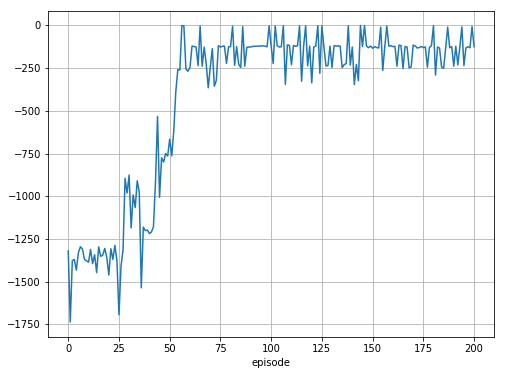

In [75]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.plot(scores)
plt.xlabel('episode')
plt.grid()